In [6]:
%pylab inline

Exploring The Bold Monitor
===============================================================

This tutorial explores the different functions used to model the haemodynamic response function (HRF) to compute the BOLD (Blood Oxygenation Level Dependent) signal. 

In the current implementation (1.1.3) TVB has HRF kernels:

1. a Gamma function,
2. a difference of two damped oscillators, 
3. a first order Volterra kernel, and
4. a mixture of gamma functions. 

Setup
-----

We are not going to run a simulation, so we'll only import TVB's monitors to access the parameters of BOLD monitor:

In [7]:
import tvb.simulator.monitors as monitors

*Bold Monitor*
--------



Let's start by creating an instance of the Bold monitor with its default parameters:

In [8]:
bold = monitors.Bold()

In general, the sampling period of a monitor is in milliseconds and must be an integral multiple of the integration-step size used in a simulation. 

Therefore, monitors need to know the integration time step (*dt*) because some data reduction mechanims (eg, downsampling to the monitor's sampling period) depend on it. An easy way to achieve this is:

In [9]:
bold.dt = 2**-4 # Default value used in the scripts found at tvb/simulator/demos

HRFs are TVB Equation datatypes, and you can explore their attributes, for instance:

* which equation we use,

In [10]:
bold.hrf_kernel #Which equation

FirstOrderVolterra(bound=False, value=None)

* its symbolic expression,

In [11]:
bold.hrf_kernel.equation

'1/3. * exp(-0.5*(var / tau_s)) * (sin(sqrt(1./tau_f - 1./(4.*tau_s**2)) * var)) / (sqrt(1./tau_f - 1./(4.*tau_s**2)))'

* or its configurable parameters,

In [12]:
bold.hrf_kernel.parameters

{'V_0': 0.02, 'k_1': 5.6, 'tau_f': 0.4, 'tau_s': 0.8}

The default kernel is the **Volterra kernel**. The shape of this function depends on the following parameters: 

1. $\tau_s$, rate constant of signal decay;
2. $\tau_f$, rate constant of feedback regulation;

* $V_0$ and $k_1$ are parameters used in the monitor to scale the amplitude of the response. See [1]. 

Let's have a look at the function:

In [13]:
bold.compute_hrf()

By default, the method **compute_hrf** gives the reflected version of the HRF. The product between this reflected HRF and the monitor's neural activity history (convolution) yields the BOLD signal. In python the indexing [::-1] will give the HRF kernel as often seen in scientific publications. 

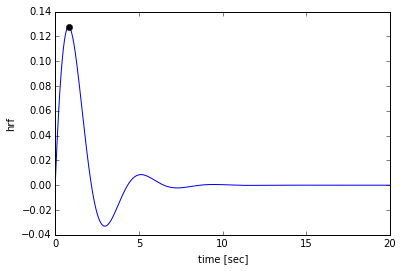

In [14]:
# plot the kernel
plt.plot(bold._stock_time, bold.hemodynamic_response_function.T[::-1]); 
plt.ylabel('hrf');
plt.xlabel('time [sec]')

# plot the maximum
plt.plot(bold._stock_time[bold.hemodynamic_response_function.T[::-1].argmax()], bold.hemodynamic_response_function.T[::-1].max(), 'ko')

In [15]:
print 'Rising peak is around %1.2f seconds' % bold._stock_time[bold.hemodynamic_response_function.T[::-1].argmax()]

Exploring other HRF kernels
---------------------------

 
First, we will create new instances of the Bold monitor.

Second, the equation defining the hrf kernel has to be changed. To achieve this we will make use of the predefined functions as Equations datatypes 

In [16]:
import tvb.datatypes.equations as equations

* In [2] they used a simple gamma function; in [3] a difference of damped oscillators was fitted to functional data from the visual cortex; the mixture of gammas is the function used in softwares like SPM. 

In [17]:
hrf_kernels = [equations.FirstOrderVolterra(), equations.DoubleExponential(), equations.MixtureOfGammas(),equations.Gamma()]

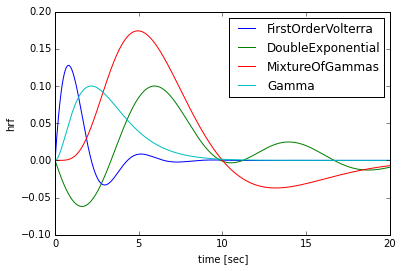

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
for hrf in hrf_kernels: 
    bold_monitor = monitors.Bold(hrf_kernel=hrf)
    bold_monitor.dt = 2**-4
    bold_monitor.compute_hrf()
    ax.plot(bold_monitor._stock_time, bold_monitor.hemodynamic_response_function.T[::-1], label=hrf.__class__.__name__);

plt.ylabel('hrf');
plt.xlabel('time [sec]')    
plt.legend()

We'll now change another parameter, the HRF duration, which by default is set to 20 [s], as in [6]. However, in SPM, the default kernel is 32 [s] (see [7]). 

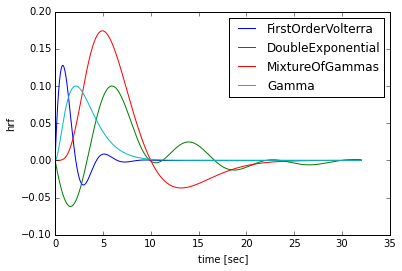

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
for hrf in hrf_kernels: 
    bold_monitor = monitors.Bold(hrf_kernel=hrf, hrf_length=32000)
    bold_monitor.dt = 2**-4
    bold_monitor.compute_hrf()
    ax.plot(bold_monitor._stock_time, bold_monitor.hemodynamic_response_function.T[::-1], label=hrf.__class__.__name__);

plt.ylabel('hrf');
plt.xlabel('time [sec]')    
plt.legend()

* [1] Friston, K., Mechelli, A., Turner, R., and Price, C., *Nonlinear Responses in fMRI: The Balloon Model, Volterra Kernels, and Other Hemodynamics*, NeuroImage, 12, 466 - 477, 2000. 

* [2] Geoffrey M. Boynton, Stephen A. Engel, Gary H. Glover and David J. Heeger (1996). *Linear Systems Analysis of Functional Magnetic Resonance Imaging in Human V1*. J Neurosci 16: 4207-4221

* [3] Alex Polonsky, Randolph Blake, Jochen Braun and David J. Heeger (2000). *Neuronal activity in human primary visual cortex correlates with perception during binocular rivalry*. Nature Neuroscience 3: 1153-1159

* [4] Glover, G. *Deconvolution of Impulse Response in Event-Related BOLD fMRI*. NeuroImage 9, 416-429, 1999.

* [5] Have a look at this tutorial: http://nbviewer.ipython.org/github/practical-neuroimaging/pna-notebooks/blob/master/convolution.ipynb

* [6] Drysdale, P. M.; Huber, J. P.; Robinson, P. A. & Aquino, K. M. *Spatiotemporal BOLD dynamics from a poroelastic hemodynamic model*. J Theor Biol, 2010, 265, 524–534

* [7] http://en.wikibooks.org/wiki/SPM/Haemodynamic_Response_Function
